<a href="https://colab.research.google.com/github/Chetan2003/RTT-Estimation-for-mobile-to-mobile/blob/main/HagosPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler

# 1. Hyperparameters directly from the paper
LEARNING_RATE = 0.001
BETA_1 = 0.9
BETA_2 = 0.999
EPOCHS = 100
BATCH_SIZE = 256
N_SPLITS = 5
TEST_SIZE = 0.40
SEQ_LENGTH = 50
FEATURES = 1

# ---------------------------------------------------------
# 2. Real Data Loading & Preprocessing
# ---------------------------------------------------------
print("Loading master dataset...")
df = pd.read_csv("hagos_wired_rtt.csv")

# Extract the RTT column as a 2D array
raw_rtt_data = df['Raw_RTT_ms'].values.reshape(-1, 1)

# Normalization is standard practice to help LSTM convergence
scaler = MinMaxScaler()
normalized_rtt = scaler.fit_transform(raw_rtt_data)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+1:i+seq_length+1])
    return np.array(X), np.array(y)

X_full, y_full = create_sequences(normalized_rtt, SEQ_LENGTH)

# Split into 60% Training, 40% Testing
X_train_split, X_test, y_train_split, y_test = train_test_split(
    X_full, y_full, test_size=TEST_SIZE, shuffle=False
)

# ---------------------------------------------------------
# 3. Build Model (Strict Hagos Architecture)
# ---------------------------------------------------------
def build_hagos_model():
    model = Sequential()
    # Multilayer LSTM cell
    model.add(LSTM(units=64, return_sequences=True, input_shape=(SEQ_LENGTH, FEATURES)))
    model.add(LSTM(units=64, return_sequences=True))

    # 15-dimensional hidden states with ReLU
    model.add(TimeDistributed(Dense(units=15, activation='relu')))

    # Final output predicted RTT (y_t)
    model.add(TimeDistributed(Dense(units=1, activation='linear')))

    optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# ---------------------------------------------------------
# 4. Training (Single Holdout Run)
# ---------------------------------------------------------
print("\n--- Starting Single Training Run ---")

# We already split the data earlier into X_train_split and X_test using train_test_split.
# We will just use those directly.

model = build_hagos_model()

# Train the model once
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_test, y_test), # Watch the test error drop in real-time
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# ---------------------------------------------------------
# 5. Final Evaluation
# ---------------------------------------------------------
print("\nFinal Evaluation on 40% Test Set...")
test_loss, test_mae = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Mean Squared Error: {test_loss}")

# Save the model
model.save("hagos_baseline_model.keras") # Saved in modern format!
print("Model saved as hagos_baseline_model.keras")

Loading master dataset...

--- Starting Single Training Run ---
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.1047 - mae: 0.2536 - val_loss: 0.0133 - val_mae: 0.0696
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0114 - mae: 0.0600 - val_loss: 0.0077 - val_mae: 0.0475
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0072 - mae: 0.0469 - val_loss: 0.0052 - val_mae: 0.0411
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0049 - mae: 0.0398 - val_loss: 0.0035 - val_mae: 0.0328
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033 - mae: 0.0318 - val_loss: 0.0023 - val_mae: 0.0241
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0022 - mae: 0.0225 - val_loss: 0.0016 - val_mae: 0.0181
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016 - mae: 0.0178 - val_loss: 0.0012 - val_mae: 0.0154
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0012 - mae: 0.0154 - val_loss: 9.4359e-04 - val_mae: 0.0135
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.40

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


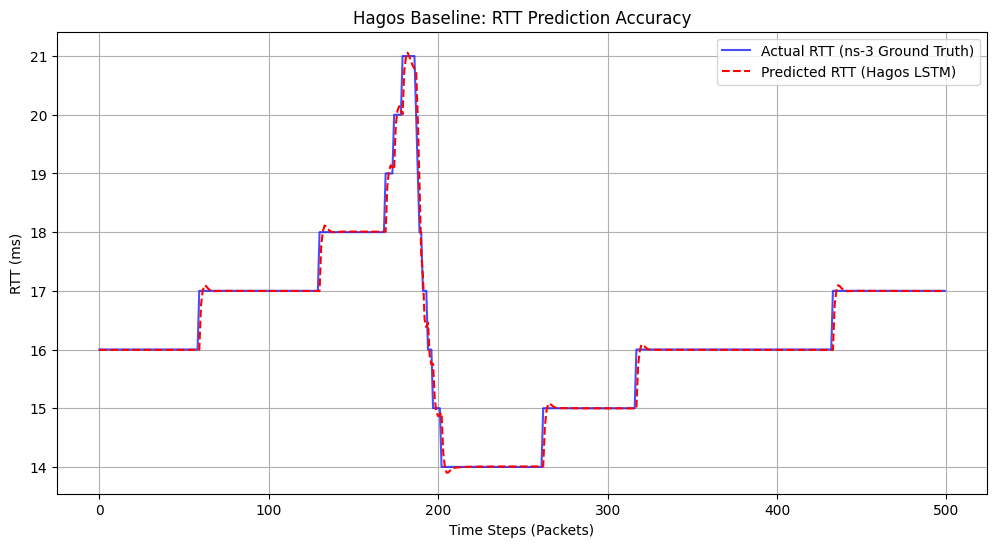

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# 1. Load the same data and scaler used in training
df = pd.read_csv("hagos_wired_rtt.csv")
raw_rtt_data = df['Raw_RTT_ms'].values.reshape(-1, 1)

scaler = MinMaxScaler()
normalized_rtt = scaler.fit_transform(raw_rtt_data)

# 2. Load the trained model
model = load_model("hagos_baseline_model.h5", compile=False)

# 3. Prepare a test window (e.g., the last 500 samples)
SEQ_LENGTH = 50
test_data = normalized_rtt[-550:]

X_test = []
y_actual = []

for i in range(len(test_data) - SEQ_LENGTH):
    X_test.append(test_data[i:i+SEQ_LENGTH])
    y_actual.append(test_data[i+SEQ_LENGTH])

X_test = np.array(X_test)
y_actual = np.array(y_actual)

# 4. Predict
y_pred_norm = model.predict(X_test)

# We only want the last prediction in each sequence for a simple 1D plot
y_pred_final = y_pred_norm[:, -1, 0].reshape(-1, 1)

# 5. Inverse Transform to get back to Milliseconds
y_pred_ms = scaler.inverse_transform(y_pred_final)
y_actual_ms = scaler.inverse_transform(y_actual.reshape(-1, 1))

# 6. Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_actual_ms, label='Actual RTT (ns-3 Ground Truth)', color='blue', alpha=0.7)
plt.plot(y_pred_ms, label='Predicted RTT (Hagos LSTM)', color='red', linestyle='--')
plt.title('Hagos Baseline: RTT Prediction Accuracy')
plt.xlabel('Time Steps (Packets)')
plt.ylabel('RTT (ms)')
plt.legend()
plt.grid(True)
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step


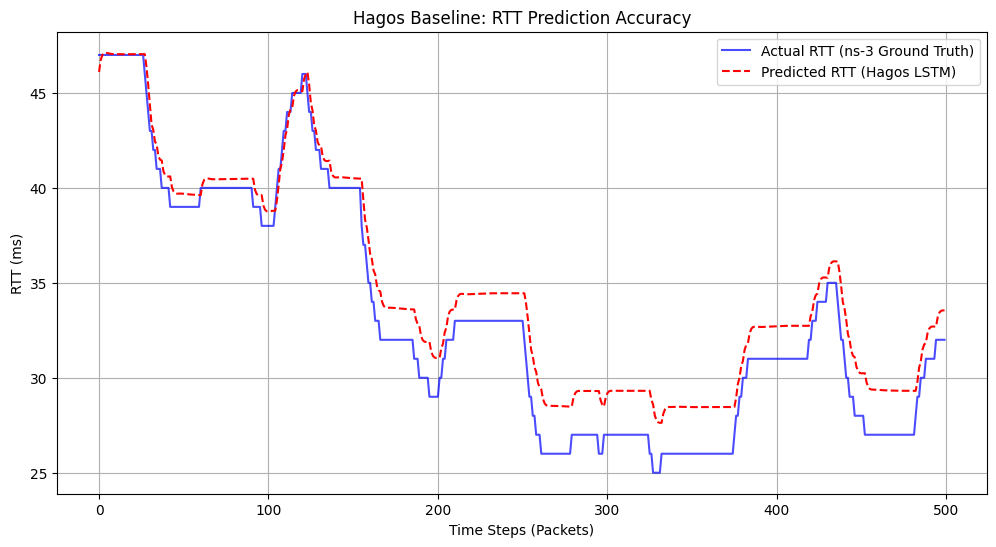

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# 1. Load the same data and scaler used in training
df = pd.read_csv("hagos_wireless_nakagami.csv")
raw_rtt_data = df['Raw_RTT_ms'].values.reshape(-1, 1)

scaler = MinMaxScaler()
normalized_rtt = scaler.fit_transform(raw_rtt_data)

# 2. Load the trained model
model = load_model("hagos_baseline_model.h5", compile=False)

# 3. Prepare a test window (e.g., the last 500 samples)
SEQ_LENGTH = 50
test_data = normalized_rtt[-550:]

X_test = []
y_actual = []

for i in range(len(test_data) - SEQ_LENGTH):
    X_test.append(test_data[i:i+SEQ_LENGTH])
    y_actual.append(test_data[i+SEQ_LENGTH])

X_test = np.array(X_test)
y_actual = np.array(y_actual)

# 4. Predict
y_pred_norm = model.predict(X_test)

# We only want the last prediction in each sequence for a simple 1D plot
y_pred_final = y_pred_norm[:, -1, 0].reshape(-1, 1)

# 5. Inverse Transform to get back to Milliseconds
y_pred_ms = scaler.inverse_transform(y_pred_final)
y_actual_ms = scaler.inverse_transform(y_actual.reshape(-1, 1))

# 6. Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_actual_ms, label='Actual RTT (ns-3 Ground Truth)', color='blue', alpha=0.7)
plt.plot(y_pred_ms, label='Predicted RTT (Hagos LSTM)', color='red', linestyle='--')
plt.title('Hagos Baseline: RTT Prediction Accuracy')
plt.xlabel('Time Steps (Packets)')
plt.ylabel('RTT (ms)')
plt.legend()
plt.grid(True)
plt.show()